In [23]:
#Import Statements
import numpy as np
import pandas as pd
import nltk
import re
import time
import sklearn.metrics
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt

## Data Exploration

In [24]:
#Importing the dataset
df = pd.read_csv('IMDB Dataset.csv')


print(df.shape)
print(df.dtypes)
df.head(10)


(50000, 2)
review       object
sentiment    object
dtype: object


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


From printing this dataset, we can see that there are 50,000 rows/entries, and two columns. These two columns are the two independent variables of the dataset: review, which contains the contents of the movie review, and sentiment, which tells whether the review is positive or negative. 

In [25]:

print(df.sentiment[df.sentiment == "positive"].count())
print(df.sentiment[df.sentiment == "negative"].count())
df.groupby('sentiment').count()



25000
25000


,review
sentiment,
negative,25000
positive,25000


Counting the number of positive and negative reviews in the entire dataset. After printing these statements, we can see that there are exactly the same number of positive and negative reviews, meaning that the data follows a uniform distribution.

In [26]:

print(df.sentiment[df.sentiment == ""].count())
print(df.review[df.review == ""].count())



0
0


Counting the number of rows that have empty/missing text in them. In this case, there are no entries that are missing any data, so no entries need to be filled in.

## Pre-processing

In [27]:

df = df.drop_duplicates()
print(df.sentiment[df.sentiment == "positive"].count())
print(df.sentiment[df.sentiment == "negative"].count())
print(df.shape)
df.groupby('sentiment').count()


24884
24698
(49582, 2)


,review
sentiment,
negative,24698
positive,24884


According to the source of the dataset there are 49582 unique entries, but there are 50k given entries, so these extra duplicate values should be removed before the data is processed. The pandas drop_duplicates() function will return the same dataframe without duplicate rows. Then, to verify that the rows were dropped, the number of positive and negative reviews are printed.

In [28]:


#download stopwords from nltk(natural language toolkit) library
nltk.download('stopwords')
stopWords = set(stopwords.words('english'))

#lemmatize:making all forms of words the same,
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer() 

reviews = np.array(df.iloc[:,0])
sentiments = np.array(df.iloc[:,1])
newReviews = []

for review in reviews:

    #make all text lowercase
    review = review.lower()

    #BeautifulSoup library is used for html parsing and web scraping. Here it is used to remove HTML tags from the text  
    review = BeautifulSoup(review,"html.parser").get_text()

    #Remove punctuation by using re, regular expressions. ^a-z : ^ is not operator, so replace any character that is not a-z with empty string
    review =  re.sub('[^a-z]', ' ', review)

    #split the review text into an array where each element is a single word in the review
    review = review.split()
 
    #go through every word in the review, if it isnt part of the stopwords list then add it to the newly processed review. Combine the new array and append it to the new reviews list.
    review = [word for word in review if not word in stopWords]

    #go thru every word and lemmatize
    review = [lemmatizer.lemmatize(word) for word in review]


    review = ' '.join(review)
    newReviews.append(review)

#replace the old reviews column with the newly processed review column
df.drop(df.columns[0], axis = 1, inplace = True)
df[0] = newReviews
df.columns = ['sentiment', 'review']
colList = list(df)
colList[1],colList[0] = colList[0],colList[1]
df = df[colList]

reviews = df.iloc[:,0].values
sentiments = df.iloc[:,1].values

#Encoding the sentiment variable for each dataset using label encoding: 0->positive, 1->negative
label_sentiments = []
for sentiment in sentiments:
    if sentiment == "positive":
        label_sentiments.append(0)
    elif sentiment == "negative":
        label_sentiments.append(1)



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pizza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pizza\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



We have to clean the text before it can be properly turned into numerical data. There are many extra characters such as punctuation that needs to be removed, so I use python's re library to remove all characters that are not letters a-z after making everything lowercase. Additionally, the BeautifulSoup library is used to parse the entire review text to remove html tags (<br>). 

There are many words in each review that do not add extra meaning in a sentence(if,or,but,and,etc) These words are called stopwords, and the nltk library has a preset list of these stopwords that we can use in our code to filter out and remove any word that is in that list. These words do not help in determining a positive or negative review, so they are removed to trim the text of each review to make them easier to process.

The final step here is lemmatization, which is the process of making similar versions of a word in to the same word, such as making plural terms of a word into its singular form. This helps cut down on the number of unique words in the dataset. When the data is transformed into numerical data, it will need to keep track of the frequency of each word, and since these words of different versions have the same meaning, they should be treated as just one word.

In [29]:

label_sentiments = []
for sentiment in sentiments:
    if sentiment == "positive":
        label_sentiments.append(0)
    elif sentiment == "negative":
        label_sentiments.append(1)

Here we are encoding the sentiment variable using label encoding. In this dataset, a 0 will represent a positive review and a 1 will represent a negative review. The labels should be in a seperate variable as it will need to be a seperate input parameter when we use our machine learning functions.

## Feature Extraction

In [30]:

#Convert text to vectors
countVec = CountVectorizer(max_features = 1000)

#convert to nparray
countVec_reviews = countVec.fit_transform(reviews).toarray()



print(countVec_reviews)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


I am using the Bag of Words model to create vectors of numbers out of the text in order to process during the machine learning task. CountVectorizer in scikit-learn is used here to do this. It will count the frequency of every word that appears in each text review and then return the array of those frequencies. This is done for every review, and the final output is an array of each review that has been turned into a vector of word frequencies.The max_features attribute is set to 1000 to standardize the number of features for every review, since each review is of different length so they would have different features if the max number of features is not limited.

In [31]:



X_train, X_test, y_train, y_test = train_test_split(countVec_reviews, label_sentiments, test_size=1, random_state=0)

X_train = countVec_reviews
y_train = label_sentiments

#convert to dataframe to do iloc later
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)



Putting all of the dataset into X_train, and the labels into y_train to be used as training data to set up for k fold cross validation later on, so I use the train_test_split function in sklearn to do this. We want to have the data and labels seperate when we fit the data to a model and train it.

## Dataset Processing

In [32]:
#First Method-  Support Vector Classifier

#K-Folds
KFolds = KFold(5)
KFolds.get_n_splits(X_train)


C = [100, 50, 10, 1, .5]
tol = [50, 10, 1, .1, .01]

i = 0
for training,testing in KFolds.split(X_train):
    X_train_kfold, X_test_kfold = X_train.iloc[training], X_train.iloc[testing]
    y_train_kfold, y_test_kfold = y_train.iloc[training],y_train.iloc[testing]

    #Cross Validation for C parameter, want to have constant tol to properly tune C
    SVCmodel = SVC(C = C[i], kernel = 'rbf', tol = 50, decision_function_shape = 'ovo',max_iter=1000)
    SVCmodel.fit(X_train_kfold,y_train_kfold)

    SVCpredictions = SVCmodel.predict(X_test_kfold)
    SVCaccuracy = sklearn.metrics.accuracy_score(y_test_kfold,SVCpredictions)
    SVCmeanSquareError = sklearn.metrics.mean_squared_error(y_test_kfold,SVCpredictions)

    print("C =",C[i],": Accuracy Score =",SVCaccuracy, "Mean Square Error =", SVCmeanSquareError)
    
    i += 1



C = 100 : Accuracy Score = 0.49682363618029646 Mean Square Error = 0.5031763638197035
C = 50 : Accuracy Score = 0.5123525259655137 Mean Square Error = 0.4876474740344862
C = 10 : Accuracy Score = 0.48497377974989914 Mean Square Error = 0.5150262202501008
C = 1 : Accuracy Score = 0.49989915288422754 Mean Square Error = 0.5001008471157725
C = 0.5 : Accuracy Score = 0.4965711980637354 Mean Square Error = 0.5034288019362646


The first classification method I am using for this dataset is a Support Vector Classifier. I am using the SVC function in sklearn. The goal of a SVC is to find the equation of a hyperplane, and to plot samples with the hyperplane and try to maximize the distance(the margin) of the hyperplane from all samples in the dataset. This function will use a hard margin classifier, where samples are not allowed to be within or on the margins. The function for the hyperplane needs the normal vector w, and a bias term b. Since this is a binary classification, I am using a one vs one classifier. I use a radial kernel here because a linear hyperplane would be more innacurate due to the amount of features, a linear model would not be able to properly fit the data. 

The C parameter is the slack budget which helps determine the regularization parameter that is multiplied by the hard margin distance. The sum of the hard margin distances will be smaller than the sums of the hard margins of each sample. 

I use k-fold cross validation with the KFold functions from sklearn. The purpose of doing k-fold cross validation here is to tune our parameters over multiple iterations so see which paramater value gives the lowest error. Since there is no seperate test data, the data is split into 5 folds. In each iteration, one fold is used as testing data while the rest of the folds are used as training data. This repeats until every fold has been used as testing data. 

The reason a Support Vector Classifier is being used in this dataset is because the two classes in the dataset can be represented easily by the two different distances from the hyperplane. Additionally, even though there are a large number of features, SVC is a good for this dataset because it can create a non linear hyperplane to be used as the decision boundary.


In [33]:
tol = [50, 10, 1, .1, .01]
i = 0


for training,testing in KFolds.split(X_train):
    X_train_kfold, X_test_kfold = X_train.iloc[training], X_train.iloc[testing]
    y_train_kfold, y_test_kfold = y_train.iloc[training],y_train.iloc[testing]

    #Cross Validation for tolerance parameter
    SVCmodel = SVC(C = 100, kernel = 'rbf', tol = tol[i], decision_function_shape = 'ovo',max_iter=1000)
    SVCmodel.fit(X_train_kfold,y_train_kfold)

    SVCpredictions = SVCmodel.predict(X_test_kfold)
    SVCaccuracy = sklearn.metrics.accuracy_score(y_test_kfold,SVCpredictions)
    SVCmeanSquareError = sklearn.metrics.mean_squared_error(y_test_kfold,SVCpredictions)

    print("Tolerance =",tol[i],": Accuracy Score =",SVCaccuracy, "Mean Square Error =", SVCmeanSquareError)
    
    i += 1


Tolerance = 50 : Accuracy Score = 0.49682363618029646 Mean Square Error = 0.5031763638197035
Tolerance = 10 : Accuracy Score = 0.5123525259655137 Mean Square Error = 0.4876474740344862
Tolerance = 1 : Accuracy Score = 0.6354376764824526 Mean Square Error = 0.3645623235175474
Tolerance = 0.1 : Accuracy Score = 0.6387656313029447 Mean Square Error = 0.3612343686970553
Tolerance = 0.01 : Accuracy Score = 0.6523799919322307 Mean Square Error = 0.34762000806776927


In the previous cell, I was doing k fold cross validation to tune for C. In this cell, I am following the same process to tune the tol parameter. This is a parameter in sklearn machine learning functions that tells the function to stop finding a min or max once the model is within the threshold of the tolerance. In this case, the model would stop searching for the min of its primal formulation once the margin is close enough to the tolerance threshold.  

In [34]:
#Use best parameters Tolerance = 1,C=50

sumSVCError = 0
sumSVCAccuracy = 0
svmTime = 0

for training,testing in KFolds.split(X_train):
    startTime = time.time()
    X_train_kfold, X_test_kfold = X_train.iloc[training], X_train.iloc[testing] 
    y_train_kfold, y_test_kfold = y_train.iloc[training],y_train.iloc[testing]

    #Cross Validation for tolerance parameter(look up other parameters)
    SVCmodel = SVC(C = 50, kernel = 'rbf', tol = 1, decision_function_shape = 'ovo',max_iter=1000)
    SVCmodel.fit(X_train_kfold,y_train_kfold)

    SVCpredictions = SVCmodel.predict(X_test_kfold)
    SVCaccuracy = sklearn.metrics.accuracy_score(y_test_kfold,SVCpredictions)
    SVCmeanSquareError = sklearn.metrics.mean_squared_error(y_test_kfold,SVCpredictions)
    sumSVCError += SVCmeanSquareError
    sumSVCAccuracy += SVCaccuracy
    svmTime += time.time() - startTime


    print("Accuracy Score =",SVCaccuracy, "Mean Square Error =", SVCmeanSquareError)
    
print("\nAverage Accuracy Score:",sumSVCAccuracy/5, "Average Error:",sumSVCError/5)



Accuracy Score = 0.6189371785822325 Mean Square Error = 0.3810628214177675
Accuracy Score = 0.5936271049712615 Mean Square Error = 0.4063728950287385
Accuracy Score = 0.6175877369907221 Mean Square Error = 0.38241226300927794
Accuracy Score = 0.586627672448568 Mean Square Error = 0.41337232755143205
Accuracy Score = 0.6403791851553046 Mean Square Error = 0.35962081484469544

Average Accuracy Score: 0.6114317756296177 Average Error: 0.38856822437038224


Once the best parameters have been found, I run the SVC function one more time with k fold cross validation to average the accuracy and error across each fold to determine its performance. The mean squared error is the sum of the observed value minus the predicted value squared for every sample, divided by the number of data samples. This is a percentage of how many misclassifications were made in the dataset.

In [35]:
#Second Method: K Nearest Neighbor

KFolds = KFold(5)
KFolds.get_n_splits(X_train)

k = [3,4,5,6,7]

i = 0

for training,testing in KFolds.split(X_train):
    X_train_kfold, X_test_kfold = X_train.iloc[training], X_train.iloc[testing]
    y_train_kfold, y_test_kfold = y_train.iloc[training],y_train.iloc[testing]

    #Cross Validation for k, brute=brute force search, weights based on distance,p=2 euclidean distance,
    KNNmodel = KNeighborsClassifier(n_neighbors=k[i], algorithm = 'brute', weights = 'distance',p=2 ,n_jobs=-1)
    KNNmodel.fit(X_train_kfold,y_train_kfold)

    KNNpredictions = KNNmodel.predict(X_test_kfold)
    KNNaccuracy = sklearn.metrics.accuracy_score(y_test_kfold,KNNpredictions)
    KNNmeanSquareError = sklearn.metrics.mean_squared_error(y_test_kfold,KNNpredictions)
   

    print("K =",k[i],": Accuracy Score =",KNNaccuracy, "Mean Square Error =", KNNmeanSquareError)
    
    i += 1



K = 3 : Accuracy Score = 0.6404154482202279 Mean Square Error = 0.3595845517797721
K = 4 : Accuracy Score = 0.6348694161540789 Mean Square Error = 0.3651305838459211
K = 5 : Accuracy Score = 0.6561113352158128 Mean Square Error = 0.34388866478418717
K = 6 : Accuracy Score = 0.6599435256151674 Mean Square Error = 0.3400564743848326
K = 7 : Accuracy Score = 0.6653892698668818 Mean Square Error = 0.3346107301331182


The second method I chose is K Nearest Neighbors(KNN). I chose KNN for this dataset because it is non parametric, meaning it can work well with many different datasets and it does not need a particular distribution of data. This works well with this text dataset, since the data is coming from vectors of word frequencies, it is likely to not follow any particular distribution unless the data was processed further. It also requires the labels to be known, and since I am using supervised data, choosing KNN makes sense here.

KNN works by using a given distance calculation metric to calculate distances between every point relative to each other. Then, for each sample, KNN looks at the k smallest distances from that sample, and uses majority vote on the labels of those k smallest distances to determine the label of the current sample. 

The KNeighborsClassifier in sklearn is used to implement KNN. The number of neighbors,k, is the parameter that is being tuned here. The algorithm parameter is set to brute, which will just calculate distances for each sample from every single other sample. Setting weights to distance tells the function to use the distances as the metric for determining the K-nearest neighbors. p = 2 is the parameter that determines the distance metric, which in this case is euclidean distance. The n_jobs parameter simply tells the function to search for neighbors in parallel, increasing the overall speed of the function.


In [36]:
#Best K value is K=7

sumKNNError = 0
sumKNNAccuracy = 0
knnTime = 0

for training,testing in KFolds.split(X_train):
    startTime = time.time()
    X_train_kfold, X_test_kfold = X_train.iloc[training], X_train.iloc[testing]
    y_train_kfold, y_test_kfold = y_train.iloc[training],y_train.iloc[testing]

    KNNmodel = KNeighborsClassifier(n_neighbors=7, algorithm = 'brute', weights = 'distance',p=2 ,n_jobs=-1)
    KNNmodel.fit(X_train_kfold,y_train_kfold)

    KNNpredictions = KNNmodel.predict(X_test_kfold)
    KNNaccuracy = sklearn.metrics.accuracy_score(y_test_kfold,KNNpredictions)
    KNNmeanSquareError = sklearn.metrics.mean_squared_error(y_test_kfold,KNNpredictions)
    sumKNNError += KNNmeanSquareError
    sumKNNAccuracy += KNNaccuracy
    knnTime += time.time() - startTime

    print("Accuracy Score =",KNNaccuracy, "Mean Square Error =", KNNmeanSquareError)

print("\nAverage Accuracy Score:",sumKNNAccuracy/5, "Average Error:",sumKNNError/5)



Accuracy Score = 0.6605828375516789 Mean Square Error = 0.33941716244832104
Accuracy Score = 0.661792880911566 Mean Square Error = 0.338207119088434
Accuracy Score = 0.6705324727712787 Mean Square Error = 0.32946752722872125
Accuracy Score = 0.6624647035094796 Mean Square Error = 0.3375352964905204
Accuracy Score = 0.6653892698668818 Mean Square Error = 0.3346107301331182

Average Accuracy Score: 0.6641524329221771 Average Error: 0.33584756707782304


Once the k value has been tuned for, that value is used again in k fold cross validation to obtain an average accuracy and error over multiple validation folds.

In [37]:
#Third Method- Logistic Regression

KFolds = KFold(5)
KFolds.get_n_splits(X_train)

C = [10, 5, 1, .1, .01]
tol = [50, 10, 1, .1, .01]

i = 0
for training,testing in KFolds.split(X_train):
    X_train_kfold, X_test_kfold = X_train.iloc[training], X_train.iloc[testing]
    y_train_kfold, y_test_kfold = y_train.iloc[training],y_train.iloc[testing]

    #Cross Validation for C parameter, lower c is stronger regularization
    REGmodel = LogisticRegression(tol = 1, C = C[i],solver="liblinear",max_iter=1000)
    REGmodel.fit(X_train_kfold,y_train_kfold)

    REGpredictions = REGmodel.predict(X_test_kfold)
    REGaccuracy = sklearn.metrics.accuracy_score(y_test_kfold,REGpredictions)
    REGmeanSquareError = sklearn.metrics.mean_squared_error(y_test_kfold,REGpredictions)
    
    print("C =",C[i],": Accuracy Score =",REGaccuracy, "Mean Square Error =", REGmeanSquareError)
    
    i += 1

C = 10 : Accuracy Score = 0.8577190682666129 Mean Square Error = 0.1422809317333871
C = 5 : Accuracy Score = 0.8506604820006051 Mean Square Error = 0.149339517999395
C = 1 : Accuracy Score = 0.8521581282775312 Mean Square Error = 0.14784187172246874
C = 0.1 : Accuracy Score = 0.854578459056071 Mean Square Error = 0.145421540943929
C = 0.01 : Accuracy Score = 0.8550826946349335 Mean Square Error = 0.14491730536506656


The third method I am using is logistic regression. I use logistic regression here because it is a binary classification method that works well if the data is not overfitted, which this dataset is not, since there are more samples than there are features, so logistic regression is a good fit for this dataset. Logistic regression works by learning a boundary from calculating prior probabilities. The MAP rule selects the probability that is greater to be used in the calculation of the normal vector(w) and the bias(b) of the boundary, which in the case of this use of logistic regression, is linear. From the calculation of the maximum likelihood estimation, we can learn w and b. by maximizing this calculation. 

Here I am using cross validation with k folds for tuning the C parameter in the LogisticRegression function in sklearn. Here, C is the inverse of the regularization parameter. The lower the C, the stronger the regularization will be as a result. This parameter is used in the calculation in the loss function for logistic regression, which controls how sparse the normal vector will be. The liblinear parameter is used for the solver to tell the function to use a linear classification for this dataset. 



In [38]:
KFolds = KFold(5)
KFolds.get_n_splits(X_train)

tol = [10, 5, 1, .1, .01]

i = 0
for training,testing in KFolds.split(X_train):
    X_train_kfold, X_test_kfold = X_train.iloc[training], X_train.iloc[testing]
    y_train_kfold, y_test_kfold = y_train.iloc[training],y_train.iloc[testing]

    #Cross Validation for tolerance parameter
    REGmodel = LogisticRegression(tol = tol[i], C = .1,solver="liblinear",max_iter=1000)
    REGmodel.fit(X_train_kfold,y_train_kfold)

    REGpredictions = REGmodel.predict(X_test_kfold)
    REGaccuracy = sklearn.metrics.accuracy_score(y_test_kfold,REGpredictions)
    REGmeanSquareError = sklearn.metrics.mean_squared_error(y_test_kfold,REGpredictions)

    print("Tolerance =",tol[i],": Accuracy Score =",REGaccuracy, "Mean Square Error =", REGmeanSquareError)
    
    i += 1

Tolerance = 10 : Accuracy Score = 0.5031763638197035 Mean Square Error = 0.49682363618029646
Tolerance = 5 : Accuracy Score = 0.4876474740344862 Mean Square Error = 0.5123525259655137
Tolerance = 1 : Accuracy Score = 0.8520572811617588 Mean Square Error = 0.14794271883824123
Tolerance = 0.1 : Accuracy Score = 0.86304961678096 Mean Square Error = 0.13695038321903993
Tolerance = 0.01 : Accuracy Score = 0.8606292860024203 Mean Square Error = 0.13937071399757966


In the previous cell, I was doing k fold cross validation to tune for C. In this cell, I am following the same process to tune the tol parameter. This is a parameter in sklean machine learning functions that tells the function to stop finding a min or max once the model is within the threshold of the tolerance. In this case, the model would stop searching for the maximum likelihood estimation once it is close enough to the tolerance threshold.  

In [39]:
#Best parameters, C = 10, Tolerance = .1

sumREGError = 0
sumREGAccuracy = 0
regTime=0

for training,testing in KFolds.split(X_train):
    startTime = time.time()
    X_train_kfold, X_test_kfold = X_train.iloc[training], X_train.iloc[testing]
    y_train_kfold, y_test_kfold = y_train.iloc[training],y_train.iloc[testing]

    REGmodel = LogisticRegression(tol = .1, C = 10,solver="liblinear",max_iter=1000)
    REGmodel.fit(X_train_kfold,y_train_kfold)

    REGpredictions = REGmodel.predict(X_test_kfold)
    REGaccuracy = sklearn.metrics.accuracy_score(y_test_kfold,REGpredictions)
    REGmeanSquareError = sklearn.metrics.mean_squared_error(y_test_kfold,REGpredictions)
    sumREGError += REGmeanSquareError
    sumREGAccuracy += REGaccuracy
    regTime += time.time() - startTime

    print("Accuracy Score =",REGaccuracy, "Mean Square Error =", REGmeanSquareError)

print("\nAverage Accuracy Score:",sumREGAccuracy/5, "Average Error:",sumREGError/5)

Accuracy Score = 0.8679035998789957 Mean Square Error = 0.13209640012100435
Accuracy Score = 0.8583240899465564 Mean Square Error = 0.14167591005344357
Accuracy Score = 0.8569987898346108 Mean Square Error = 0.14300121016538928
Accuracy Score = 0.8624445340863252 Mean Square Error = 0.13755546591367487
Accuracy Score = 0.8600242033077854 Mean Square Error = 0.1399757966922146

Average Accuracy Score: 0.8611390434108547 Average Error: 0.13886095658914532


Once the best parameters have been found, I run the logistic regression function one more time with k fold cross validation to average the accuracy and error accross each fold to determine its performance.



## Comparative Analysis

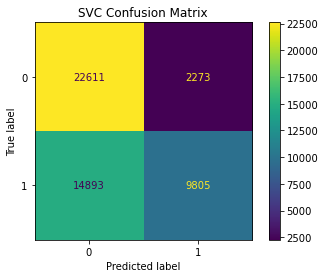

In [40]:
#Confusion Matrices

svcMatrix = sklearn.metrics.plot_confusion_matrix(SVCmodel,X_train,y_train)
plt.title("SVC Confusion Matrix")
plt.show()



Positives(class 0->positive review),Negatives(class 1->positive review)

SVC True Positives: 22611

SVC False Positives: 2273

SVC False Negatives: 14893

SVC True Negatives: 9805


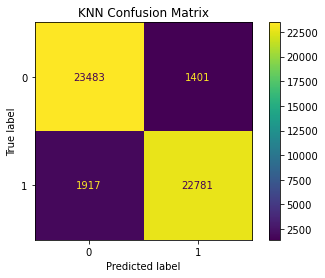

In [41]:
knnMatrix = sklearn.metrics.plot_confusion_matrix(KNNmodel,X_train,y_train)
plt.title("KNN Confusion Matrix")
plt.show()

KNN True Positives: 23483

KNN False Positives: 1401

KNN False Negatives: 1917

KNN True Negatives: 22781

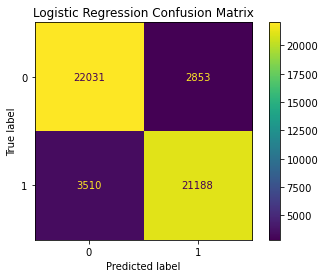

In [42]:
regMatrix = sklearn.metrics.plot_confusion_matrix(REGmodel,X_train,y_train)
plt.title("Logistic Regression Confusion Matrix")
plt.show()

Logistic Regression True Positives: 22031

Logistic Regression False Positives: 2853

Logistic Regression False Negatives: 3510

Logistic Regression True Negatives: 21188

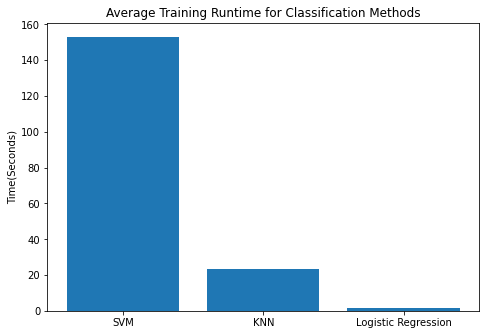

In [43]:
#Plot of average training runtime for each method, each time is run 5 times(for 5 k folds)

plot = plt.figure()
xlabels=['SVM','KNN','Logistic Regression']
values = [svmTime/5,knnTime/5,regTime/5]
fig = plot.add_axes([0,0,1,1])
fig.bar(xlabels,values)
plt.title('Average Training Runtime for Classification Methods')
plt.ylabel('Time(Seconds)')
plt.show()


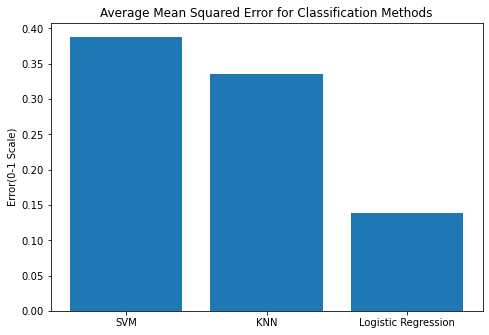

In [44]:
#Plot of average error for each method, 5 errors averaged across each k fold

plot = plt.figure()
xlabels=['SVM','KNN','Logistic Regression']
values = [sumSVCError/5,sumKNNError/5,sumREGError/5]
fig = plot.add_axes([0,0,1,1])
fig.bar(xlabels,values)
plt.title('Average Mean Squared Error for Classification Methods')
plt.ylabel('Error(0-1 Scale)')
plt.show()

From the above two plots comparing the mean squared error and average runtime of the three different classification methods that were used, logistic regression has both the fastest runtime and the lowest error, making it the best choice for this dataset. Despite the fact that knn had lower false positive and false negative rates than logistic regression did, when averaged over multiple folds logistic regression had much less error and the runtime is significantly less, making it the best pick for production in this dataset.

## Ethical Issues

The ethical issues with this dataset come from the fact that the sentiment analysis being performed is not being done by an actual person. Movie reviews are something that is very subjective and varies from person to person doing the review. People reading movie reviews should be able to determine by themselves how the reviewer felt about the movie review that they are writing, and a machine making the decision would not have the same subjective basis as a person reading the review.

## Bibliography

Pedregosa, Fabian, et al. “Scikit-Learn: Machine Learning in Python.” Journal of Machine Learning Research, 1 Jan. 2011, jmlr.csail.mit.edu/papers/v12/pedregosa11a.html. 

Rautela, Yashvardhan. “Python: Lemmatization with NLTK.” GeeksforGeeks, 6 Nov. 2018, www.geeksforgeeks.org/python-lemmatization-with-nltk/. 

Richardson, Leonard. “Beautiful Soup Documentation¶.” Beautiful Soup Documentation - Beautiful Soup 4.9.0 Documentation, www.crummy.com/software/BeautifulSoup/bs4/doc/. 

Shalini, Baranwal. “Strip Punctuation with Regex - Python.” Stack Overflow, 25 Aug. 2013, stackoverflow.com/questions/18429143/strip-punctuation-with-regex-python/50985687. 

Upadhyay, Pratima. “Removing Stop Words with NLTK in Python.” GeeksforGeeks, 24 Nov. 2020, www.geeksforgeeks.org/removing-stop-words-nltk-python/. 

Verma, Khushali. “Using CountVectorizer to Extracting Features from Text.” GeeksforGeeks, 17 July 2020, www.geeksforgeeks.org/using-countvectorizer-to-extracting-features-from-text/. 


